In [1]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


In [3]:
IMG_SIZE = 224
IMAGE_DIR = r'C:\Users\Nana Casmana\Documents\KULIAH\PROJECT NANA\PROJECT NANA\skin_disease_detection\data\images'
CSV_PATH = r'C:\Users\Nana Casmana\Documents\KULIAH\PROJECT NANA\PROJECT NANA\skin_disease_detection\data\HAM10000_metadata.csv'

df = pd.read_csv(CSV_PATH)
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])

X, y = [], []
for i in tqdm(range(len(df))):
    img_path = os.path.join(IMAGE_DIR, df['image_id'][i] + '.jpg')
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        y.append(df['label'][i])

X = np.array(X) / 255.0
y = to_categorical(y, num_classes=len(le.classes_))


100%|██████████| 10015/10015 [00:51<00:00, 195.69it/s]


In [20]:
# Tampilkan urutan label
print("Urutan label:", list(le.classes_))

Urutan label: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [19]:
print("Jumlah kelas:", len(le.classes_))
print("Shape y:", y.shape)
print("Contoh y[0]:", y[0])

Jumlah kelas: 7
Shape y: (10015, 7)
Contoh y[0]: [0. 0. 1. 0. 0. 0. 0.]


In [4]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)


In [5]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [6]:
def build_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

model = build_model((IMG_SIZE, IMG_SIZE, 3), num_classes=len(le.classes_))
model.compile(optimizer=Adam(5e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
# y_integers = np.argmax(y_train, axis=1)
# class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
# class_weights_dict = dict(enumerate(class_weights))

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    ModelCheckpoint('skin_model_final_3.keras', save_best_only=True, monitor='val_loss', mode='min')
]


In [8]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (6009, 224, 224, 3)
y_train shape: (6009, 7)
X_val shape: (2003, 224, 224, 3)
y_val shape: (2003, 7)


In [9]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=callbacks
)


c:\Program Files\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.5449 - loss: 1.5377 - val_accuracy: 0.6950 - val_loss: 0.8632 - learning_rate: 5.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 138s 736ms/step - accuracy: 0.6641 - loss: 1.0005 - val_accuracy: 0.7159 - val_loss: 0.8225 - learning_rate: 5.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 140s 743ms/step - accuracy: 0.6850 - loss: 0.9154 - val_accuracy: 0.7199 - val_loss: 0.7986 - learning_rate: 5.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 139s 737ms/step - accuracy: 0.7034 - loss: 0.8649 - val_accuracy: 0.7099 - val_loss: 0.7939 - learning_rate: 5.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 139s 739ms/step - accuracy: 0.7074 - loss: 0.8203 - val_accuracy: 0.7249 - val_loss: 0.7728 - learning_rate: 5.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 142s 754ms/step - accuracy: 0.7141 - loss: 0.7941 - val_accuracy: 0.7259 - val_loss: 0.7600 - learning_rate: 5.0000e-04
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 136

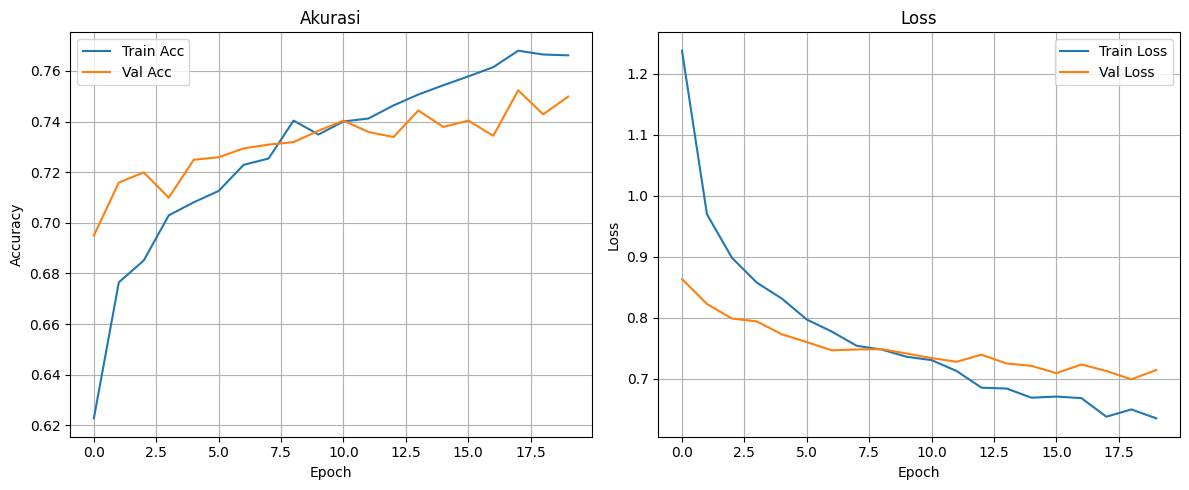

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [14]:
print("\nEvaluasi pada Data Test:")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
print(f"✅ Akurasi Test Set: {test_acc * 100:.2f}%")


Evaluasi pada Data Test:
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 495ms/step - accuracy: 0.7412 - loss: 0.7409
Test Loss: 0.7208, Test Accuracy: 0.7494
✅ Akurasi Test Set: 74.94%


In [17]:
# Prediksi
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 497ms/step

=== Classification Report ===
              precision    recall  f1-score   support

       akiec       0.83      0.08      0.14        65
         bcc       0.59      0.35      0.44       103
         bkl       0.48      0.40      0.43       220
          df       0.00      0.00      0.00        23
         mel       0.48      0.39      0.43       223
          nv       0.82      0.95      0.88      1341
        vasc       0.72      0.46      0.57        28

    accuracy                           0.75      2003
   macro avg       0.56      0.38      0.41      2003
weighted avg       0.72      0.75      0.72      2003



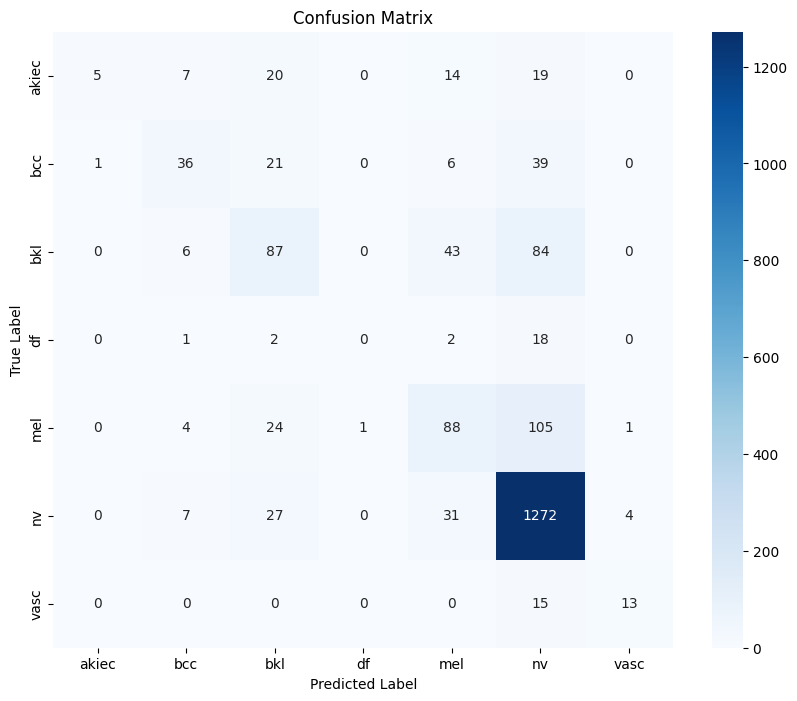

In [18]:


cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [16]:
# save model
model.save(r'C:\Users\Nana Casmana\Documents\KULIAH\PROJECT NANA\PROJECT NANA\skin_disease_detection\models\skin_model_final_3.keras')
